# Stock Price Prediction using LSTM

In [1]:
# import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Down load data
# stock_symbol = 'AAPL'  # Apple Inc. 
# start_date = '2016-01-01'
# end_date = '2022-01-01'
# stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Save data as .csv file
# csv_file_path = 'stock_data1.csv'
# stock_data.to_csv(csv_file_path, index=True)

In [3]:
# Read data
csv_file_path = 'stock_data1.csv'
stock_data = pd.read_csv(csv_file_path)

In [4]:
# Extract closing prices as target values
features = ['Open', 'High', 'Low', 'Volume']  # Add other features as needed
target_column = 'Close'
stock_prices = stock_data[features + [target_column]]
stock_prices

,Open,High,Low,Volume,Close
0,25.652500,26.342501,25.500000,270597600,26.337500
1,26.437500,26.462500,25.602501,223164000,25.677500
2,25.139999,25.592501,24.967501,273829600,25.174999
3,24.670000,25.032499,24.107500,324377600,24.112499
4,24.637501,24.777500,24.190001,283192000,24.240000
...,...,...,...,...,...
1506,177.089996,180.419998,177.070007,74919600,180.330002
1507,180.160004,181.330002,178.529999,79144300,179.289993
1508,179.330002,180.630005,178.139999,62348900,179.380005
1509,179.470001,180.570007,178.089996,59773000,178.199997


In [5]:
# Data preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))
stock_prices_scaled = scaler.fit_transform(stock_prices)

# Convert data to PyTorch Tensor
seq_length = 7  # input sequence length
X, y = [], []

for i in range(len(stock_prices_scaled) - seq_length):
    X.append(stock_prices_scaled[i:i + seq_length, :])
    y.append(stock_prices_scaled[i + seq_length, -1])  # Close is the last column


X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [6]:
y.shape

torch.Size([1504, 1])

In [7]:
X.shape

torch.Size([1504, 7, 5])

In [8]:
# Split into training and testing sets
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

y_test.shape

torch.Size([151, 1])

In [9]:
# Create DataLoader
batch_size = 64

X_train, X_test = X_train.to('cpu'), X_test.to('cpu')
y_train, y_test = y_train.to('cpu'), y_test.to('cpu')

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# Define LSTM model
class StockPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(StockPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [11]:
# Initialize model and optimizer
input_size = len(features)+1  # number of features 
hidden_size = 30
output_size = 1  # predicted closing price
num_epochs = 40
learning_rate = 0.001

model = StockPricePredictor(input_size, hidden_size, output_size)
model = model.to('cpu')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [12]:
# Train the model
for epoch in range(num_epochs):
    for batch_inputs, batch_targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/40], Loss: 0.0048
Epoch [20/40], Loss: 0.0007
Epoch [30/40], Loss: 0.0002
Epoch [40/40], Loss: 0.0003


In [13]:
# Predict on the test set
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

In [14]:
test_predictions.shape

torch.Size([151, 1])

In [15]:
y_test.shape

torch.Size([151, 1])

In [16]:
# Compute metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Squared Error (MSE): 0.02
Root Mean Squared Error (RMSE): 0.13


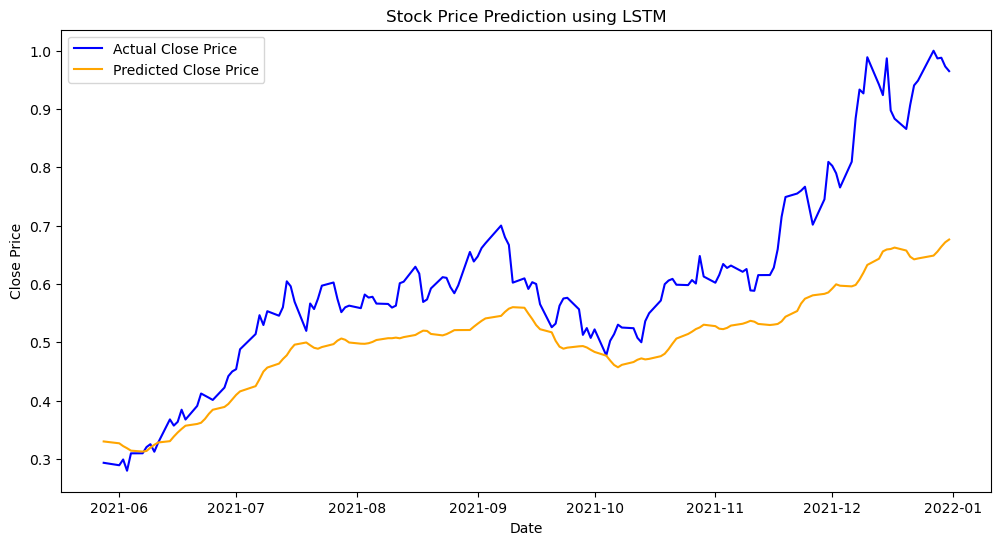

In [17]:
# Extract dates index from test data
dates = pd.to_datetime(stock_data.iloc[-len(test_predictions):, 0])

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Close Price', color='blue')
plt.plot(dates, test_predictions, label='Predicted Close Price', color='orange')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()